In [16]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [17]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('btc.csv')
df1=df.reset_index()['Close']

In [18]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [19]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [20]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [21]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [22]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [23]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 5s 121ms/step - loss: 0.0380 - val_loss: 0.0047
Epoch 2/100
20/20 [==============================] - 2s 79ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 3/100
20/20 [==============================] - 2s 77ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 4/100
20/20 [==============================] - 1s 58ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 5/100
20/20 [==============================] - 1s 52ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 6/100
20/20 [==============================] - 1s 63ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 7/100
20/20 [==============================] - 1s 52ms/step - loss: 0.0020 - val_loss: 7.5513e-04
Epoch 8/100
20/20 [==============================] - 1s 30ms/step - loss: 0.0018 - val_loss: 6.8987e-04
Epoch 9/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0017 - val_loss: 7.2626e-04
Epoch 10/100
20/20 [==============================] - 0s 25ms/step - loss: 0.0016 - val

In [25]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 9ms/step


In [26]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [27]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAE, MAPE
print('---------VALIDATE----------')
valid_mape = np.mean(np.abs( (yval - y_pred_val) / yval )) * 100
print('MAPE:', valid_mape)
valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)
print('---------TEST-------------')
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)
test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

---------VALIDATE----------
MAPE: 7326124.697967728
MAE: 65814.65412587566
RMSE: 65888.48871306427
---------TEST-------------
MAPE: 8224695.700446879
MAE: 28470.965773405194
RMSE: 28664.485740444292


In [28]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.68583501 0.67756889 0.68967404 0.69201294 0.73224787 0.76921984
 0.84739737 0.82855187 0.84647189 0.84054613 0.85695541 0.93143461
 0.86609866 0.89935805 0.91116787 0.93099723 0.93386485 0.94137915
 0.98615743 0.97688739 1.         0.97566562 0.9469183  0.88793761
 0.93230318 0.9201565  0.83885728 0.92542292 0.89048043 0.86577499
 0.86986376 0.91562083 0.95492499 0.95534366 0.94766222 0.96626542
 0.95397313 0.9504025  0.97475761 0.95122249 0.88983968 0.89754056
 0.93400854 0.92432613 0.93959502 0.9463237  0.97905222 0.94309905
 0.96399961 0.95639345 0.91506827 0.86639112 0.89404836 0.86068929
 0.8662525  0.82968151 0.86193771 0.86670989 0.88331172 0.88233372
 0.90990125 0.90369245 0.87296084 0.87591529 0.86543684 0.8605873
 0.85617441 0.86667455 0.82045159 0.78607801 0.7986198  0.85295184
 0.8674009  0.86941556 0.8568772  0.84494544 0.82840125 0.85526172
 0.82270083 0.8227143  0.8321584  0.85311937 0.83366434 0.90167604
 0.88673257 0.91299111 0.91138888 0.90183292 0.9764

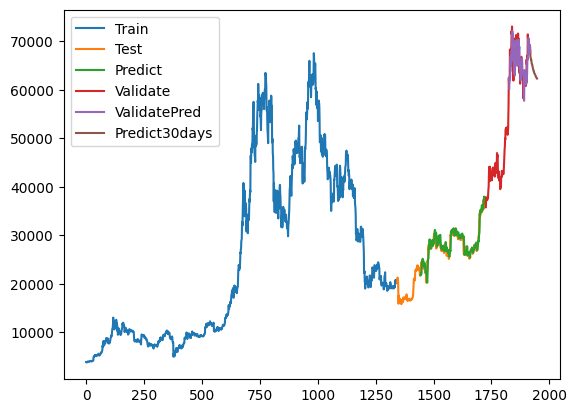

In [29]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()